In [1]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.autograd import Variable
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian, DiagGGNMC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
from bpjacext import NetJac
import pytest
from DirLPA_utils import * 

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

#NOTE: DO NOT RUN THIS CODE: the function NetJac comes from a private repository that is not yet available for you. 
#If you search for it aggressively you might find out my identity. I would therefore prefer if you just looked at the provided results.

# make plots work

153


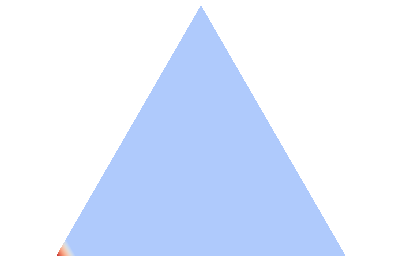

In [204]:
# just copy pasted from this link: http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
%matplotlib inline
import numpy as np
import matplotlib.tri as tri
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma, gammaln, xlogy

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def logit_transform(x):
    
    out = np.log(x/(1-x))
    return(out)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        #x = softmax_transform(x)
        return(np.exp(- self._coef+ np.sum((xlogy(self._alpha-1, x.T)).T, 0)))
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.linalg.inv(np.array(Sigma))
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.Sigma_inv = np.linalg.inv(np.array(Sigma))
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const /np.prod(x*(1-x))
        logit = logit_transform(x)
        part_two = np.exp(-0.5*(logit - self.mu).T @ self.Sigma_inv @ (logit - self.mu))
        y = part_one * part_two
        return(y)
    
class softmaxNormal3D(object):
    
    def __init__(self, mu, Sigma, c):
        self.mu = np.array(mu)
        self.c = c * np.ones(len(mu))
        self.Sigma = np.array(Sigma)
        self.Sigma_inv = np.linalg.inv(np.array(Sigma))
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const/ np.prod(1/x)
        sm_inv = np.log(x) + self.c
        part_two = np.exp(-0.5*(sm_inv - self.mu).T @ self.Sigma_inv @ (sm_inv - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, nlevels=200, subdiv=4, filename='test.png',**kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    cs = plt.tricontourf(trimesh, pvals, nlevels, cmap=new_coolwarm) #plasma, inferno is OK
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('figures/{}'.format(filename), bbox_inches = 'tight', pad_inches = 0)
    
draw_pdf_contours(Dirichlet([100, 1,1]), filename='new_coolwarm.pdf')

In [77]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_blue = cm.get_cmap('Blues', 256)
new_blue = new_blue(np.linspace(0.3,1,256))
new_blues = ListedColormap(new_blue, name='new_blues')

new_red = cm.get_cmap('Reds', 256)
new_red = new_red(np.linspace(0.3,1,256))
new_reds = ListedColormap(new_red, name='new_reds')

new_green = cm.get_cmap('Greens', 256)
new_green = new_green(np.linspace(0.3,1,256))
new_greens = ListedColormap(new_green, name='new_greens')

new_purple = cm.get_cmap('Purples', 256)
new_purple = new_purple(np.linspace(0.3,1,256))
new_purples = ListedColormap(new_purple, name='new_purples')

new_orange = cm.get_cmap('Oranges', 256)
new_orange = new_orange(np.linspace(0.3,1,256))
new_oranges = ListedColormap(new_orange, name='new_oranges')

In [134]:
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Reds', 128)


newcolors = np.vstack((top(np.linspace(0.9, 1, 128)),
                       bottom(np.linspace(0, 0.7, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [196]:
new_coolwarm = cm.get_cmap('coolwarm', 256)
new_coolwarm = new_coolwarm(np.linspace(0.35,0.95,256))
new_coolwarm = ListedColormap(new_coolwarm, name='new_coolwarm')

In [174]:
new_cool = cm.get_cmap('cool', 256)
new_cool = new_cool(np.linspace(0.3,1 ,256))
new_cool = ListedColormap(new_cool, name='new_cool')

In [187]:
new_bupu = cm.get_cmap('BuPu', 256)
new_bupu = new_bupu(np.linspace(0.4,1 ,256))
new_bupu = ListedColormap(new_bupu, name='new_bupu')

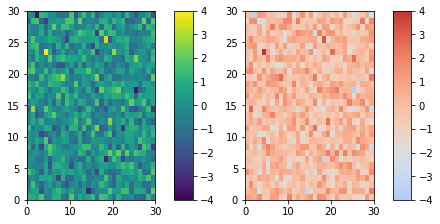

In [197]:
viridis = cm.get_cmap('viridis', 256)

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([viridis, new_coolwarm])

In [3]:
def draw_triple_pdfs(dists, nlevels=200, subdiv=6, filename='dummy.pdf', **kwargs):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(dists), sharex=False, figsize=(15, 5))
    
    for i, d in enumerate(dists):
        
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        pvals = [d.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

        cs = axs[i].tricontourf(trimesh, pvals, nlevels, cmap='cool') #plasma, inferno is OK
        for c in cs.collections:
            c.set_rasterized(True)
        axs[i].axis('equal')
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 0.75**0.5)
        axs[i].axis('off')
    
    fig.tight_layout()
    plt.savefig('figures/{}'.format(filename))
    plt.show()   

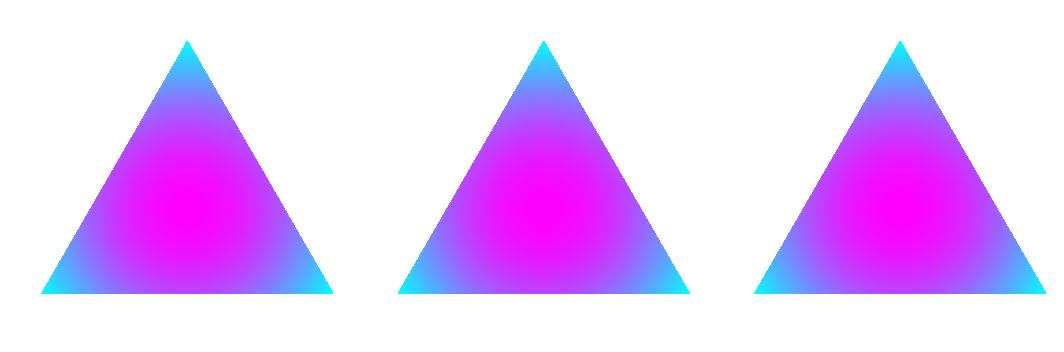

In [4]:
mu1 = np.array([0.5, 0.5, 0.5])
Sigma1 = 1*np.eye(3)
dists = [Normal3D(mu1, Sigma1), Normal3D(mu1, Sigma1), Normal3D(mu1, Sigma1)]
draw_triple_pdfs(dists)

# take subset of mnist

/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


18623
tensor([0, 1, 2,  ..., 0, 2, 1])


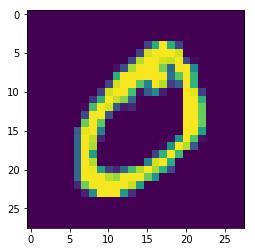

In [5]:
MNIST_transform = torchvision.transforms.ToTensor()

MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)

def get_subset_MNIST(classes=[0,1,2], dataset=MNIST_train):
    
    dataset.targets = dataset.targets.clone().detach()
    idx = torch.zeros(dataset.targets.size()).byte()
    for c in classes:
        idx += (dataset.targets==c).byte()
    dataset.targets= dataset.targets[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]
    
    #remap all classes to list of ints starting at 1
    map_dict = dict()
    for i, c in enumerate(classes):
        map_dict[c] = i
    
    for i, t in enumerate(dataset.targets):
        dataset.targets[i] = map_dict[t.item()]
    
    return(dataset.data, dataset.targets)

num_samples = "all"
classes = [0,1,2]
MNIST_train.data, MNIST_train.targets = get_subset_MNIST(classes=classes, dataset=MNIST_train)
print(len(MNIST_train.targets))
print(MNIST_train.targets)
plt.imshow(MNIST_train.data[0].numpy())

In [6]:
#get an in test and out test dataset

MNIST_test_in = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=True,
        transform=MNIST_transform)

MNIST_test_in.data, MNIST_test_in.targets = get_subset_MNIST(classes=classes, dataset=MNIST_test_in)
print(len(MNIST_test_in.targets))
print(MNIST_test_in.targets[:100])


MNIST_test_out = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=True,
        transform=MNIST_transform)

classes_out = [c for c in range(10) if c not in classes]
MNIST_test_out.data, MNIST_test_out.targets = get_subset_MNIST(classes=classes_out, dataset=MNIST_test_out)
print(len(MNIST_test_out.targets))
print(MNIST_test_out.targets[:100])

3147
tensor([2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 0, 0, 2,
        1, 2, 2, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2,
        1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2,
        2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0,
        2, 1, 2, 0])
6853
tensor([4, 1, 1, 6, 2, 6, 3, 6, 2, 6, 4, 0, 1, 6, 3, 3, 2, 1, 4, 1, 0, 0, 1, 4,
        4, 4, 1, 0, 2, 1, 1, 3, 0, 2, 2, 3, 1, 6, 2, 4, 5, 6, 0, 4, 1, 3, 1, 0,
        4, 6, 4, 0, 6, 4, 4, 3, 4, 5, 1, 4, 0, 3, 0, 3, 6, 0, 1, 4, 3, 6, 3, 2,
        1, 6, 6, 6, 1, 5, 4, 0, 6, 4, 1, 1, 1, 6, 2, 1, 4, 3, 4, 6, 2, 5, 2, 3,
        3, 2, 4, 5])


/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [7]:
BATCH_SIZE_TRAIN_MNIST = 64
BATCH_SIZE_TEST_MNIST = 32
MAX_ITER_MNIST = 6

In [8]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=BATCH_SIZE_TRAIN_MNIST,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test_in,
    batch_size=BATCH_SIZE_TRAIN_MNIST,
    shuffle=False,
)

mnist_test_out_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test_out,
    batch_size=BATCH_SIZE_TRAIN_MNIST,
    shuffle=False,
)

In [9]:
def LPADirNN(num_classes=10, num_LL=256):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 64, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 64, num_LL), #changed from 500
        torch.nn.Linear(num_LL, num_classes)  #changed from 500
    )
    return(features)

In [10]:
mnist_model = LPADirNN(num_classes=3)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
MNIST_PATH = "models/mnist_3c_{}s_6iter_256.pth".format(num_samples)

In [11]:
#Training routine

def train(verbose=False):
    for iter in range(MAX_ITER_MNIST):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            max_len = int(np.ceil(len(mnist_train_loader.dataset)/BATCH_SIZE_TRAIN_MNIST))
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                print(
                    "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                    "Minibatch Loss %.3f  " % (loss) +
                    "Accuracy %.0f" % (accuracy * 100) + "%"
                )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [12]:
#train(verbose=False)

In [13]:
#predict in distribution
MNIST_PATH = "models/mnist_3c_{}s_6iter_256.pth".format(num_samples)

mnist_model = LPADirNN(num_classes=3)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

acc = []

for batch_idx, (x, y) in enumerate(mnist_test_loader):
        max_len = int(np.ceil(len(mnist_test_loader.dataset)/BATCH_SIZE_TEST_MNIST))
        output = mnist_model(x)
        
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))


loading model from: models/mnist_3c_alls_6iter_256.pth
Batch 0/99 	Accuracy 100%
Batch 10/99 	Accuracy 100%
Batch 20/99 	Accuracy 100%
Batch 30/99 	Accuracy 100%
Batch 40/99 	Accuracy 100%
overall test accuracy on MNIST: 99.97 %


In [14]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    prob_correct = np.choose(targets, py_in.T).mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)
    
def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    if max(targets) > len(py_in[0]):
        targets = np.array(targets)
        targets[targets >= len(py_in[0])] = 0
    prob_correct = np.choose(targets, py_out.T).mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

def print_in_dist_values(acc_in, prob_correct, average_entropy, MMC, train='mnist', method='LLLA-KF'):
    
    print(f'[In, {method}, {train}] Accuracy: {acc_in:.3f}; average entropy: {average_entropy:.3f}; \
    MMC: {MMC:.3f}; Prob @ correct: {prob_correct:.3f}')


def print_out_dist_values(acc_out, prob_correct, average_entropy, MMC, auroc, train='mnist', test='FMNIST', method='LLLA-KF'):
   
    print(f'[Out-{test}, {method}, {train}] Accuracy: {acc_out:.3f}; Average entropy: {average_entropy:.3f};\
    MMC: {MMC:.3f}; AUROC: {auroc:.3f}; Prob @ correct: {prob_correct:.3f}')

# MAP estimate

In [15]:
targets = MNIST_test_in.targets.numpy()
targets_out = MNIST_test_out.targets.numpy()
print(targets_out)

[4 1 1 ... 1 2 3]


In [16]:
mnist_test_in_MAP = predict_MAP(mnist_model, mnist_test_loader).numpy()
mnist_test_out_MAP = predict_MAP(mnist_model, mnist_test_out_loader).numpy()

In [17]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(mnist_test_in_MAP, targets)
acc_out_MAP, prob_correct_out_MAP, ent_out_MAP, MMC_out_MAP, auroc_out_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_MAP, targets_out)

In [18]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'mnist', 'MAP')
print_out_dist_values(acc_out_MAP, prob_correct_out_MAP, ent_out_MAP, MMC_out_MAP, auroc_out_MAP, 'mnist_out', 'MAP')

[In, MAP, mnist] Accuracy: 1.000; average entropy: 0.006;     MMC: 0.998; Prob @ correct: 0.998
[Out-MAP, LLLA-KF, mnist_out] Accuracy: 0.098; Average entropy: 0.356;    MMC: 0.850; AUROC: 0.970; Prob @ correct: 0.291


# Laplace bridge

In [19]:
## play around with Backpack
def get_Hessian_NN(model, train_loader, var0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Hessian_diag = []
    for param in mnist_model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Hessian_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    tau = 1/var0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            mnist_model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add bias here
                    H_ += tau * torch.ones(H_.size())

                    rho = min(1-1/(batch_idx+1), 0.95)

                    Hessian_diag[idx] = rho*Hessian_diag[idx] + (1-rho)*H_
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))

    #combine all elements of the Hessian to one big vector
    Hessian_diag = torch.cat([el.view(-1) for el in Hessian_diag])
    print("Hessian_size: ", Hessian_diag.size())
    num_params = np.sum([p.numel() for p in model.parameters()])
    assert(num_params == Hessian_diag.size(-1))
    return(Hessian_diag)
        

In [20]:
Hessian_MNIST = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, var0=2,verbose=False)

parameter size:  torch.Size([32, 1, 5, 5])
parameter size:  torch.Size([32])
parameter size:  torch.Size([64, 32, 5, 5])
parameter size:  torch.Size([64])
parameter size:  torch.Size([256, 1024])
parameter size:  torch.Size([256])
parameter size:  torch.Size([3, 256])
parameter size:  torch.Size([3])
Hessian_size:  torch.Size([315267])


In [21]:
from scipy.special import digamma

def log_beta_function(alpha):
    return(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha)))

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def alpha_entropy(alpha):
    K = len(alpha)
    alpha = np.array(alpha)
    B = log_beta_function(alpha)
    #print("B: ", B)
    alpha_0 = np.sum(alpha)
    C = (alpha_0 - K)*digamma(alpha_0)
    #print("C: ", C)
    D = np.sum((alpha-1)*digamma(alpha))
    #print("D: ", D)
    entropy = B + C - D
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

In [22]:
def compute_jacobians_with_backpack(model, x, y, lossfunc):
    """
    Returns the jacobians of the network

    The output is a list. Each element in the list is a tensor
    corresponding to the model.parameters().

    The tensor are of the form [N, *, C] where N is the batch dimension,
    C is the number of classes (output size of the network)
    and * is the shape of the model parameters
    """
    #this is a bit hacky. Refactoring needed
    if max(y) > 3:
        y[y >= 3] = np.random.randint(0,3)
    
    loss = lossfunc(model(x), y)

    with backpack(NetJac()):
        loss.backward()

    jacs = []
    for p in model.parameters():
        jacs.append(p.netjacs.data)
    return jacs

def transform2full_jac(backpack_jacobian):

    jac_full = []
    #batch_size
    N = backpack_jacobian[0].size(0)
    #num classes
    k = backpack_jacobian[0].size(-1)
    for j in backpack_jacobian:
        jac_full.append(j.view(N, -1, k).permute(0,2,1))
    jac_full = torch.cat(jac_full, dim=-1)
    return(jac_full)

def get_Jacobian(model, x, y, lossfunc):
    return(transform2full_jac(compute_jacobians_with_backpack(model, x, y, lossfunc)))

In [23]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    assert(alpha.size() == mu.size())
    
    return(alpha)

In [24]:
def predict_DIR_LPA(model, test_loader, Hessian, verbose=True):

    lossfunc = torch.nn.CrossEntropyLoss()
    extend(lossfunc, debug=False)
    
    alphas = []

    max_len = len(test_loader)
    for batch_idx, (x, y) in enumerate(test_loader):

        J = get_Jacobian(model, x, y, lossfunc)
        batch_size = J.size(0)
        num_classes = J.size(1)
        Cov_pred = torch.bmm(J * Hessian, J.permute(0, 2, 1))
        #print("cov pred size: ", Cov_pred.size())
        
        mu_pred = model(x)
        
        #make sure that it fullfills all the properties:
        #mu_pred -= mu_pred.mean()
        #Cov_pred -= torch.matmul(Cov_pred.sum(dim=2).view(-1, 10, 1), Cov_pred.sum(dim=1).view(-1, 1, 10))/Cov_pred.sum(0)
        
        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
    
        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return(torch.cat(alphas, dim = 0))


In [25]:
mnist_test_in_DIR_LPA = predict_DIR_LPA(mnist_model, mnist_test_loader, Hessian_MNIST, verbose=False).numpy()
mnist_test_out_DIR_LPA = predict_DIR_LPA(mnist_model, mnist_test_out_loader, Hessian_MNIST, verbose=False).numpy()

In [26]:
#McKay
mnist_test_in_DIR_LPAn = mnist_test_in_DIR_LPA/mnist_test_in_DIR_LPA.sum(1).reshape(-1,1)
mnist_test_out_DIR_LPAn = mnist_test_out_DIR_LPA/mnist_test_out_DIR_LPA.sum(1).reshape(-1,1)

In [27]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(mnist_test_in_DIR_LPAn, targets)
acc_out_DIR_LPA, prob_correct_out_DIR_LPA, ent_out_DIR_LPA, MMC_out_DIR_LPA, auroc_out_DIR_LPA = get_out_dist_values(mnist_test_in_DIR_LPAn, mnist_test_out_DIR_LPAn, targets_out)
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'mnist', 'DIR_LPA')
print_out_dist_values(acc_out_DIR_LPA, prob_correct_out_DIR_LPA, ent_out_DIR_LPA, MMC_out_DIR_LPA, auroc_out_DIR_LPA, 'mnist_out', 'DIR_LPA')

[In, DIR_LPA, mnist] Accuracy: 0.999; average entropy: 0.010;     MMC: 0.997; Prob @ correct: 0.997
[Out-DIR_LPA, LLLA-KF, mnist_out] Accuracy: 0.107; Average entropy: 0.417;    MMC: 0.823; AUROC: 0.965; Prob @ correct: 0.284


# Make some fancy 3D Dirichlet plots

In [28]:
MAP0 = mnist_test_in_MAP[0]
MAP1 = mnist_test_in_MAP[1]
MAP2 = mnist_test_in_MAP[2]
MAP3 = mnist_test_in_MAP[3]

d0 = mnist_test_in_DIR_LPA[0]
d1 = mnist_test_in_DIR_LPA[1]
d2 = mnist_test_in_DIR_LPA[2]
d3 = mnist_test_in_DIR_LPA[3]

t0 = targets[0]
t1 = targets[1]
t2 = targets[2]
t3 = targets[3]
print(MAP0, MAP1, MAP2, MAP3)
print(d0, d1, d2, d3)
print(t0, t1, t2, t3)

[3.5528046e-07 1.7502197e-08 9.9999964e-01] [1.3341720e-05 9.9993658e-01 5.0059487e-05] [9.9999726e-01 1.1695286e-10 2.7654921e-06] [2.8933919e-06 9.9998975e-01 7.4475211e-06]
[8.0093732e-03 1.5485378e-03 2.3092896e+04] [3.3980892e-03 4.5840027e+01 9.9634668e-03] [1.6645626e+06 1.2332306e-03 1.1259163e+01] [2.3883267e-03 1.7510959e+02 6.4055836e-03]
2 1 0 1


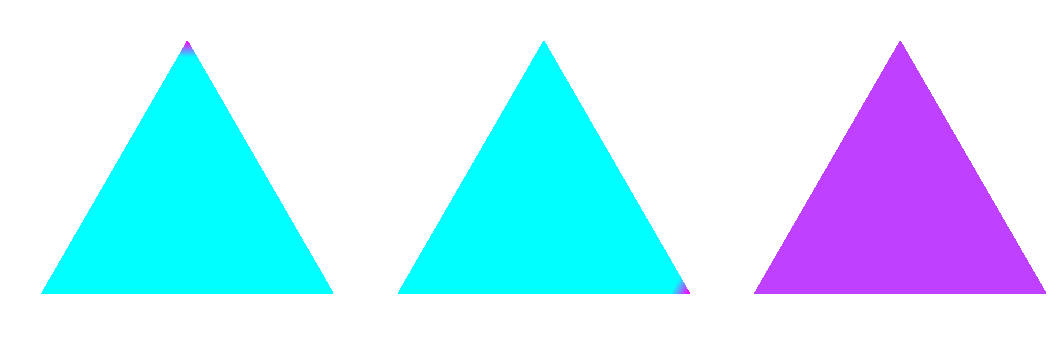

In [29]:
dists = [Dirichlet(d0), Dirichlet(d1), Dirichlet(d2)]
draw_triple_pdfs(dists, subdiv=4)

test_map:  [array([9.9997365e-01, 7.7600584e-09, 2.6307867e-05], dtype=float32), array([1.3341720e-05, 9.9993658e-01, 5.0059487e-05], dtype=float32), array([3.5528046e-07, 1.7502197e-08, 9.9999964e-01], dtype=float32)]
test_d:  [array([3.4448367e+04, 1.4654906e-03, 2.1520679e+00], dtype=float32), array([3.3980892e-03, 4.5840027e+01, 9.9634668e-03], dtype=float32), array([8.0093732e-03, 1.5485378e-03, 2.3092896e+04], dtype=float32)]
test_targets:  [0, 1, 2]


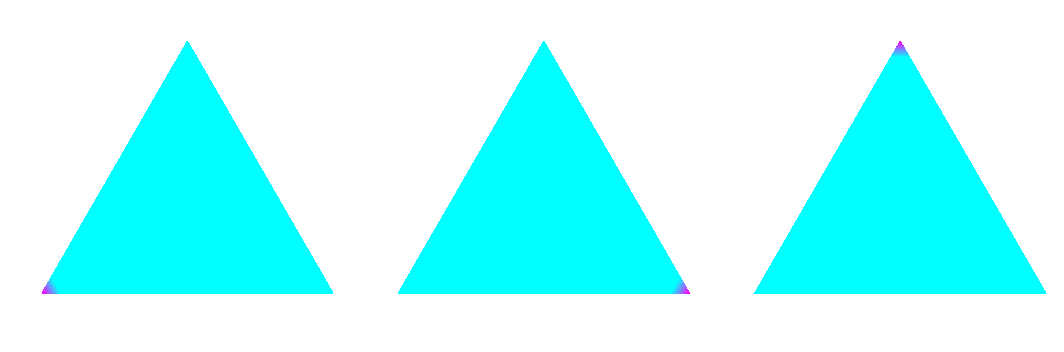

In [30]:
L = [4,1,0]
test_map = [mnist_test_in_MAP[i] for i in L]
test_d = [mnist_test_in_DIR_LPA[i] for i in L]
test_dists = [Dirichlet(d) for d in test_d]
test_targets = [targets[i] for i in L]
print("test_map: ", test_map)
print("test_d: ", test_d)
print("test_targets: ", test_targets)

draw_triple_pdfs(test_dists, subdiv=4, filename='MNIST3_in_dist_cool.pdf')

153
153
153


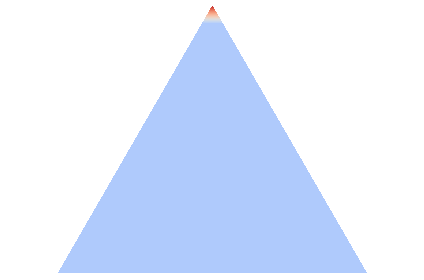

In [208]:
draw_pdf_contours(test_dists[0], filename='MNIST_3Classes_in_dist_coolwarm_0.png')
draw_pdf_contours(test_dists[1], filename='MNIST_3Classes_in_dist_coolwarm_1.png')
draw_pdf_contours(test_dists[2], filename='MNIST_3Classes_in_dist_coolwarm_2.png')

In [31]:
MAP0_MNIST_out = mnist_test_out_MAP[0]
MAP1_MNIST_out = mnist_test_out_MAP[1]
MAP2_MNIST_out = mnist_test_out_MAP[2]
MAP3_MNIST_out = mnist_test_out_MAP[3]

d0_MNIST_out = mnist_test_out_DIR_LPA[0]
d1_MNIST_out = mnist_test_out_DIR_LPA[1]
d2_MNIST_out = mnist_test_out_DIR_LPA[2]
d3_MNIST_out = mnist_test_out_DIR_LPA[3]

t0_MNIST_out = targets_out[0]
t1_MNIST_out = targets_out[1]
t2_MNIST_out = targets_out[2]
t3_MNIST_out = targets_out[3]
print(MAP0_MNIST_out, MAP1_MNIST_out, MAP2_MNIST_out, MAP3_MNIST_out)
print(d0_MNIST_out, d1_MNIST_out, d2_MNIST_out, d3_MNIST_out)
print(t0_MNIST_out, t1_MNIST_out, t2_MNIST_out, t3_MNIST_out)

[0.06142883 0.00112431 0.93744683] [8.4837115e-01 8.3218107e-04 1.5079665e-01] [2.8097574e-04 1.3998334e-02 9.8572063e-01] [0.05177294 0.03389385 0.9143332 ]
[0.02419655 0.00238411 0.5009912 ] [0.26420546 0.00284527 0.10663859] [1.1949516e-03 3.4153711e-02 1.4164920e+00] [0.00234844 0.00264499 0.02464616]
4 1 1 6


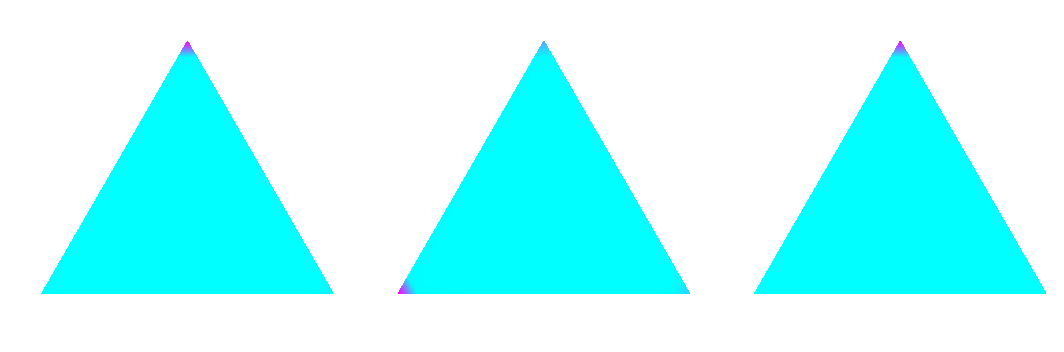

In [51]:
dists = [Dirichlet(d0_MNIST_out), Dirichlet(d1_MNIST_out), Dirichlet(d2_MNIST_out)]
#MAPs = [MAP0_MNIST_out, MAP1_MNIST_out, MAP2_MNIST_out]
draw_triple_pdfs(dists, subdiv=4)

test_map:  [array([9.6336575e-05, 6.1517805e-01, 3.8472557e-01], dtype=float32), array([0.06649538, 0.14541973, 0.788085  ], dtype=float32), array([0.9674727 , 0.01537188, 0.01715543], dtype=float32)]
test_d:  [array([9.2725403e-04, 3.1190279e+00, 1.8254831e+00], dtype=float32), array([0.00193292, 0.00630082, 0.01468987], dtype=float32), array([0.07672083, 0.00336597, 0.00508367], dtype=float32)]
test_targets:  [0, 1, 6]


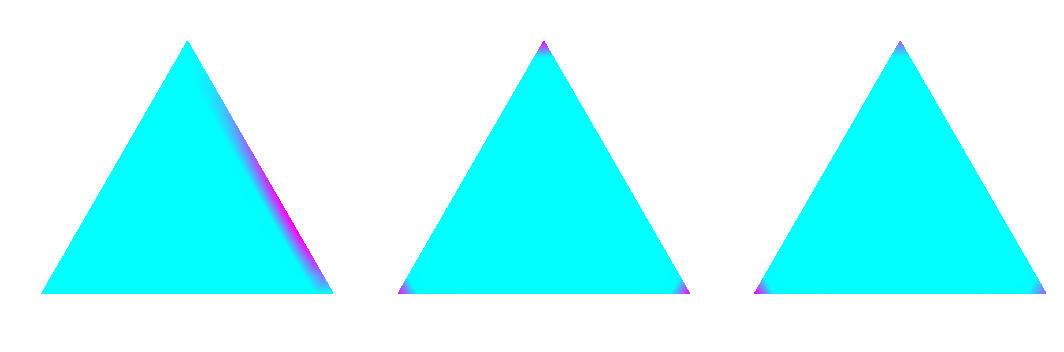

In [33]:
L = [27, 12,13]
#12, 13, 3,5, 9,10, 27
test_map_MNIST_out = [mnist_test_out_MAP[i] for i in L]
test_d_MNIST_out = [mnist_test_out_DIR_LPA[i] for i in L]
test_dists_MNIST_out = [Dirichlet(d) for d in test_d_MNIST_out]
test_targets_MNIST_out = [targets_out[i] for i in L]
print("test_map: ", test_map_MNIST_out)
print("test_d: ", test_d_MNIST_out)
print("test_targets: ", test_targets_MNIST_out)

draw_triple_pdfs(test_dists_MNIST_out, subdiv=4, filename='MNIST3_out_dist_cool.pdf')

153
153
153


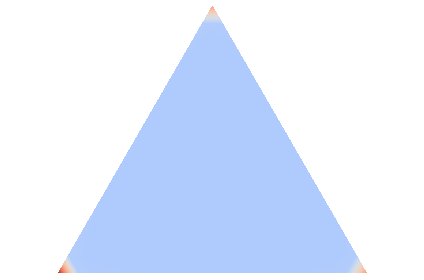

In [207]:
draw_pdf_contours(test_dists_MNIST_out[0], filename='MNIST_3Classes_out_dist_coolwarm_0.png')
draw_pdf_contours(test_dists_MNIST_out[1], filename='MNIST_3Classes_out_dist_coolwarm_1.png')
draw_pdf_contours(test_dists_MNIST_out[2], filename='MNIST_3Classes_out_dist_coolwarm_2.png')

# check out different values of the dirichlet for in and out of dist data

In [34]:
#in dist values
average_alphas_in = []
max_alphas_in = []
var_alphas_in = []
ent_alphas_in = []
for i in range(len(np.unique(targets))):
    #get all alphas beloning to that class
    alphas = mnist_test_in_DIR_LPA[np.where(targets == i)]
    #average alpha
    avg_alpha = alphas.mean(0)
    average_alphas_in.append(avg_alpha)
    print("avg: ", avg_alpha)
    #max alpha
    max_alphas = alphas.max(1)
    max_alphas_in.append(np.mean(max_alphas))
    print("max: ", np.mean(max_alphas))
    #variance
    var_alphas = alphas_variance(alphas)
    var_alphas_in.append(np.mean(var_alphas))
    print("variance: ", np.mean(var_alphas))
    #entropy
    ent_alphas = alpha_entropy(alphas)
    ent_alphas_in.append(np.mean(ent_alphas))
    print("ent: ", np.mean(ent_alphas))

avg:  [2.2477572e+06 1.6507327e-03 1.0223236e+01]
max:  2247756.2
variance:  0.00048558018
ent:  -652326.3811035156
avg:  [2.3187574e-03 2.3883066e+03 8.5313082e-01]
max:  2388.3093
variance:  0.001232555
ent:  -656084.538649559
avg:  [4.4458307e-02 1.1365943e+00 1.0001930e+09]
max:  1000193300.0
variance:  0.0002819014
ent:  -4370035.91796875


In [35]:
#out dist values
average_alphas_out = []
max_alphas_out = []
var_alphas_out = []
ent_alphas_out = []
for i in range(len(np.unique(targets_out))):
    #get all alphas beloning to that class
    alphas = mnist_test_out_DIR_LPA[np.where(targets_out == i)]
    #average alpha
    avg_alpha = alphas.mean(0)
    average_alphas_out.append(avg_alpha)
    print("avg: ", avg_alpha)
    #max alpha
    max_alphas = alphas.max(1)
    max_alphas_out.append(np.mean(max_alphas))
    print("max: ", np.mean(max_alphas))
    #variance
    var_alphas = alphas_variance(alphas)
    var_alphas_out.append(np.mean(var_alphas))
    print("variance: ", np.mean(var_alphas))
    #entropy
    ent_alphas = alpha_entropy(alphas)
    ent_alphas_out.append(np.mean(ent_alphas))
    print("ent: ", np.mean(ent_alphas))

avg:  [7.1230486e-02 4.9789951e+01 4.5818555e+02]
max:  498.77377
variance:  0.04089642
ent:  -1056580.2556965947
avg:  [0.84583646 0.11529966 0.45924535]
max:  1.3844984
variance:  0.11517044
ent:  -693102.9285977063
avg:  [  2.716013 128.6241    98.68882 ]
max:  228.72624
variance:  0.06617711
ent:  -839596.3335317075
avg:  [209.11005     0.5827736   7.6709237]
max:  216.25122
variance:  0.039771307
ent:  -516513.1898946166
avg:  [1.0817110e+02 1.3817942e+00 6.4355488e+04]
max:  64463.43
variance:  0.05828741
ent:  -673967.9851531982
avg:  [8.3150578e+00 1.4787425e-01 4.6965042e+02]
max:  477.19635
variance:  0.039117556
ent:  -730143.9095048308
avg:  [87.71242    1.5190017  5.4448795]
max:  92.734184
variance:  0.08062555
ent:  -590465.0193442255


# plot in and out of dist data

In [36]:
print("in classes: ", classes)
print("out classes: ", classes_out)
classes_in_map = dict()
for i in range(len(classes)):
    classes_in_map[i] = classes[i]
classes_out_map = dict()
for i in range(len(classes_out)):
    classes_out_map[i] = classes_out[i]
#print(classes_in_map)
#print(classes_out_map)

max_alphas_combined = np.zeros(10)
for i, x in enumerate(max_alphas_in):
    max_alphas_combined[classes_in_map[i]] = x
for i, x in enumerate(max_alphas_out):
    max_alphas_combined[classes_out_map[i]] = x
var_alphas_combined = np.zeros(10)
for i, x in enumerate(var_alphas_in):
    var_alphas_combined[classes_in_map[i]] = x
for i, x in enumerate(var_alphas_out):
    var_alphas_combined[classes_out_map[i]] = x
ent_alphas_combined = np.zeros(10)
for i, x in enumerate(ent_alphas_in):
    ent_alphas_combined[classes_in_map[i]] = x
for i, x in enumerate(ent_alphas_out):
    ent_alphas_combined[classes_out_map[i]] = x
    
print("max alphas combined: ", max_alphas_combined)
print("var alphas combined: ", var_alphas_combined)
print("ent alphas combined: ", ent_alphas_combined)

in classes:  [0, 1, 2]
out classes:  [3, 4, 5, 6, 7, 8, 9]
max alphas combined:  [2.24775625e+06 2.38830933e+03 1.00019328e+09 4.98773773e+02
 1.38449836e+00 2.28726242e+02 2.16251221e+02 6.44634297e+04
 4.77196350e+02 9.27341843e+01]
var alphas combined:  [0.00048558 0.00123256 0.0002819  0.04089642 0.11517044 0.06617711
 0.03977131 0.05828741 0.03911756 0.08062555]
ent alphas combined:  [ -652326.38110352  -656084.53864956 -4370035.91796875 -1056580.25569659
  -693102.92859771  -839596.33353171  -516513.18989462  -673967.9851532
  -730143.90950483  -590465.01934423]


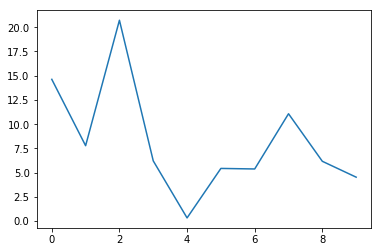

In [37]:
# plot max value
plt.plot(range(10), np.log(max_alphas_combined), label='max alphas')

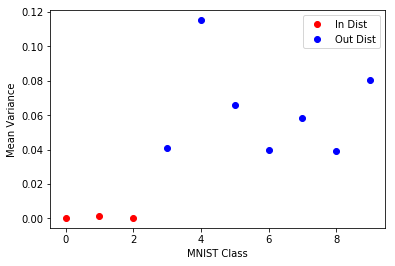

In [38]:
# plot var 
import tikzplotlib as tpl
fig = plt.figure()
plt.plot(classes, var_alphas_in, 'ro', label='In Dist')
plt.plot(classes_out, var_alphas_out, 'bo', label='Out Dist')
plt.xlabel('MNIST Class')
plt.ylabel('Mean Variance')
plt.legend();
plt.show()
#tpl.save('MNIST3VarianceOOD.tex', figure=fig, tex_relative_path_to_data='.figures', figurewidth='\\figwidth', figureheight='\\figheight')
tpl.save('MNIST3VarianceOOD.tex', figure=fig, figurewidth='\\figwidth', figureheight='\\figheight',
         extra_axis_parameters={'xtick align=outside', 'ytick align=outside', 'xtick pos=left', 'ytick pos=left', 'legend pos=north west'})

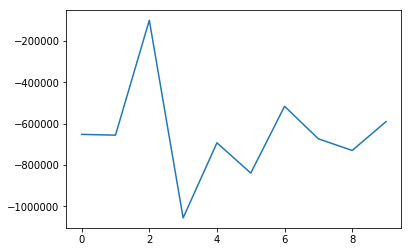

In [39]:
# plot ent
ent_alphas_combined_view = ent_alphas_combined
ent_alphas_combined_view[2] = -10e4
plt.plot(range(10), ent_alphas_combined_view)

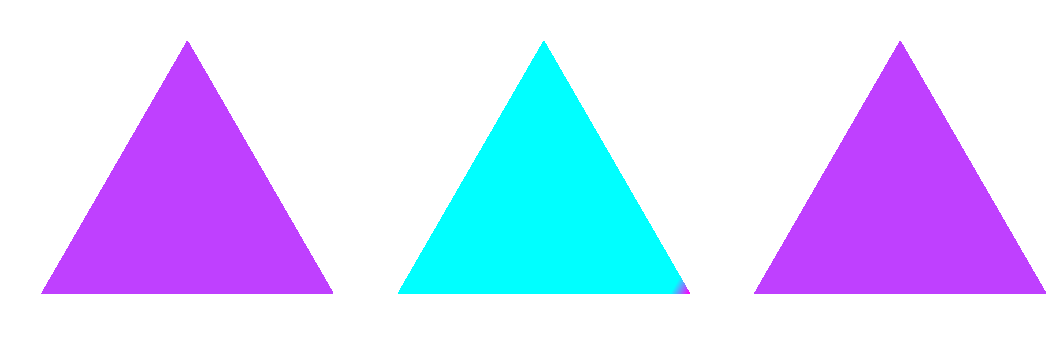

In [40]:
#plot average prediction
in_dist_avg_pred = [Dirichlet(d) for d in average_alphas_in]
draw_triple_pdfs(in_dist_avg_pred, subdiv=4)

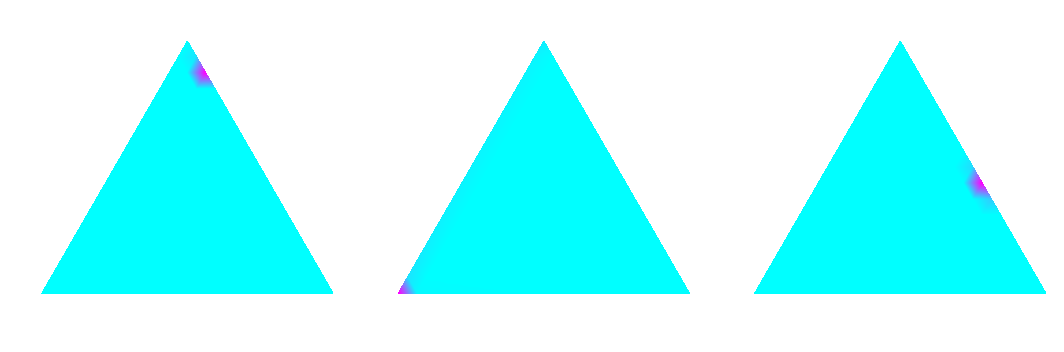

In [41]:
out_dist_avg_pred = [Dirichlet(d) for d in average_alphas_out]
draw_triple_pdfs(out_dist_avg_pred[:3], subdiv=4)

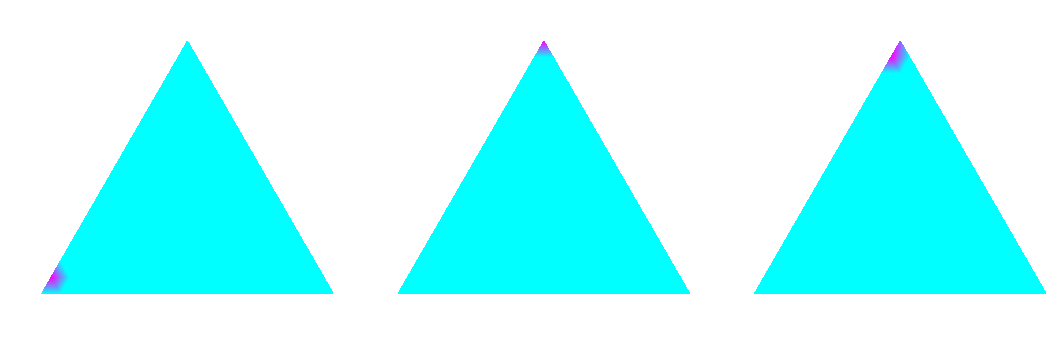

In [42]:
draw_triple_pdfs(out_dist_avg_pred[3:6], subdiv=4)


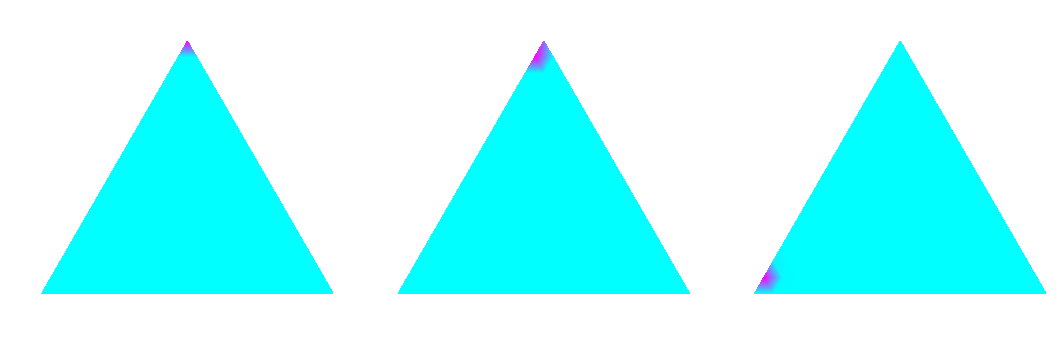

In [43]:
draw_triple_pdfs(out_dist_avg_pred[-3:], subdiv=4)